<a href="https://colab.research.google.com/github/seosumin/start-github/blob/master/keras_%EC%A0%95%EC%88%98%EC%9D%B8%EC%BD%94%EB%94%A9_%EC%9E%90%EC%86%8C%EB%B6%84%ED%95%A0_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **데이터 불러오기 **

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 155501 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
#from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# 네이버 영화리뷰 감정분석 데이터 다운로드
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 21.90 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [5]:
import pandas as pd
### 판다스로 훈련셋과 테스트셋 데이터 로드
train = pd.read_csv("nsmc/ratings_train.txt", sep='\t')
test = pd.read_csv("nsmc/ratings_test.txt", sep='\t')

print(train.shape)
print(test.shape)

(150000, 3)
(50000, 3)


In [68]:
import numpy as np
X_train =  train['document'][:20000]
X_test = test['document'][:2000]
Y_train = np.array(train['label'][:20000])
Y_test = np.array(test['label'][:2000])

## **자소 분할 하기**

In [25]:
!pip install soynlp

In [69]:
import re 
from soynlp.hangle import compose, decompose, character_is_korean

doublespace_pattern = re.compile('\s+')

def jamo_sentence(sent): 
  def transform(char): 
    if char == ' ': 
      return char 
    cjj = decompose(char) 
    if len(cjj) == 1: 
      return cjj 
    cjj_ = ''.join(c if c != ' ' else '-' for c in cjj) 
    return cjj_
#sent_ = ''.join(transform(char) for char in sent)
  sent_ =''
  for char in sent: 
    if character_is_korean(char) or char== ' ': 
      sent_ += ''.join(transform(char))
    elif character_is_korean(char) == False:
       sent_ += ''.join(' ')
  sent_ = doublespace_pattern.sub(' ', ''.join(sent_))
  return sent_

In [70]:
X_train_list=[]
for i in X_train:
  X_train_list.append(jamo_sentence(str(i)))



In [71]:
X_test_list=[]
for i in X_test:
  X_test_list.append(jamo_sentence(str(i)))


리뷰의 최대 길이 : 411
리뷰의 평균 길이 : 84.64405


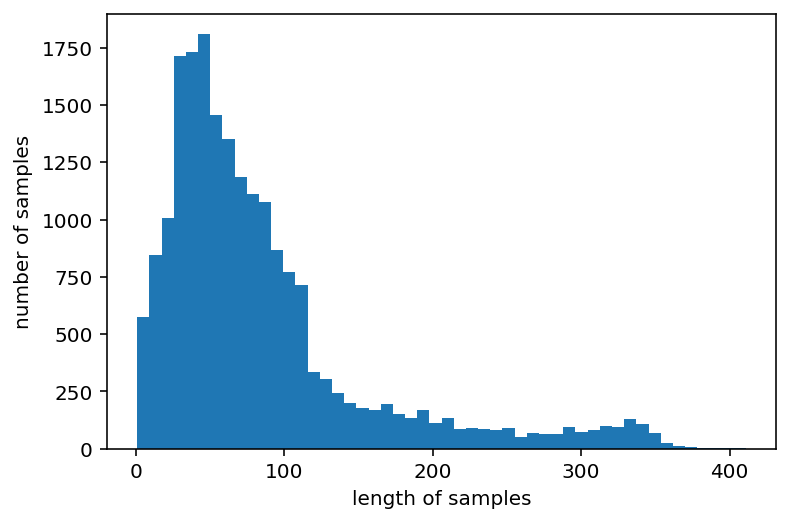

In [72]:
# train 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in X_train_list))
print('리뷰의 평균 길이 :',sum(map(len, X_train_list))/len(X_train_list))
plt.hist([len(s) for s in X_train_list], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

리뷰의 최대 길이 : 379
리뷰의 평균 길이 : 83.364


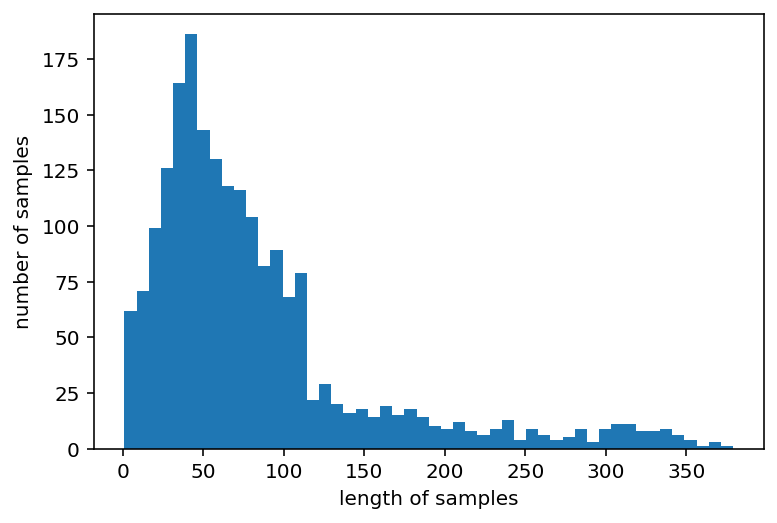

In [73]:
# test 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in X_test_list))
print('리뷰의 평균 길이 :',sum(map(len, X_test_list))/len(X_test_list))
plt.hist([len(s) for s in X_test_list], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [74]:
import tensorflow as tf
max_len = 300 # 문장길이를 얼마나 받을것인가 결정 
tokenizer = tf.keras.preprocessing.text.Tokenizer(lower=True) # 케라스 내장 토크나이저 불러오기
tokenizer.fit_on_texts(X_train_list) #(자소로 쪼개진 토큰 학습)
X_train_docs = tokenizer.texts_to_sequences(X_train_list) #토큰들을 토큰 아이디로 변경
X_train_docs = tf.keras.preprocessing.sequence.pad_sequences(X_train_docs, maxlen=max_len) # 남은 칸을 다 0으로 패딩


In [75]:
X_train_docs

array([[    0,     0,     0, ...,    15,   683,    19],
       [    0,     0,     0, ...,  2369,  2875,     8],
       [    0,     0,     0, ...,    11, 10902,  2370],
       ...,
       [    0,     0,     0, ...,    72,    34,   115],
       [    0,     0,     0, ...,    29,   297,   694],
       [    0,     0,     0, ...,    39,    21,  9432]], dtype=int32)

In [76]:
X_test_docs = tokenizer.texts_to_sequences(X_test_list)
X_test_docs = tf.keras.preprocessing.sequence.pad_sequences(X_test_docs, maxlen=max_len)

In [77]:
X_test_docs

array([[    0,     0,     0, ...,     0,  1218,     9],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,    10,    27,   917],
       ...,
       [    0,     0,     0, ..., 28689,    17,     4],
       [    0,     0,     0, ...,     8,   999,    42],
       [    0,     0,     0, ...,     1,    45,   339]], dtype=int32)

In [78]:
word_index = tokenizer.word_index
vocab_size=len(word_index) # 임베딩 사이즈로 들어가야한다. 

In [79]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Input, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras import backend as K

In [80]:
clear_session()
model1 = Sequential()
model1.add(Embedding(vocab_size + 1, 300, input_length=max_len))
model1.add(Conv1D(filters=512, kernel_size=8, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Conv1D(filters=256, kernel_size=8, padding='same', activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          8988900   
                                                                 
 conv1d (Conv1D)             (None, 300, 512)          1229312   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 150, 512)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 256)          1048832   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 75, 256)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 256)               5

In [81]:
print(len(X_train_docs), len(Y_train))

20000 20000


In [82]:
es= EarlyStopping(monitor='val_loss',
                 min_delta=0,
                 patience=10,
                 verbose=1,
                 restore_best_weights=True)
model1.fit(X_train_docs, Y_train, epochs=50, batch_size=1024, validation_split=0.2, verbose=1, callbacks=[es])

Epoch 1/50
16/16 [==============================] - 23s 1s/step - loss: 0.6849 - accuracy: 0.5381 - val_loss: 0.6114 - val_accuracy: 0.6777
Epoch 2/50
16/16 [==============================] - 15s 942ms/step - loss: 0.4965 - accuracy: 0.7602 - val_loss: 0.4838 - val_accuracy: 0.7760
Epoch 3/50
16/16 [==============================] - 16s 1s/step - loss: 0.2488 - accuracy: 0.9049 - val_loss: 0.5011 - val_accuracy: 0.7788
Epoch 4/50
16/16 [==============================] - 15s 948ms/step - loss: 0.1375 - accuracy: 0.9538 - val_loss: 0.7071 - val_accuracy: 0.7878
Epoch 5/50
16/16 [==============================] - 15s 955ms/step - loss: 0.0857 - accuracy: 0.9707 - val_loss: 0.7136 - val_accuracy: 0.7857
Epoch 6/50
16/16 [==============================] - 15s 956ms/step - loss: 0.0554 - accuracy: 0.9818 - val_loss: 0.9417 - val_accuracy: 0.7790
Epoch 7/50
16/16 [==============================] - 15s 958ms/step - loss: 0.0444 - accuracy: 0.9835 - val_loss: 1.0008 - val_accuracy: 0.7760
Epoch

In [83]:
print("\n 테스트 정확도: %.4f" % (model1.evaluate(X_test_docs, Y_test)[1]))

63/63 [==============================] - 2s 29ms/step - loss: 0.4719 - accuracy: 0.7725

 테스트 정확도: 0.7725


In [85]:
score=model1.predict(X_test_docs)

In [86]:
bi_score=[]
for i in range(len(score)):
  if score[i] > 0.5:
    bi_score.append(1)
  else:
    bi_score.append(0)

In [87]:
df_bi_score=pd.DataFrame(bi_score, columns=['score'])

In [89]:
df_bi_score

,score
0,1
1,1
2,1
3,0
4,0
...,...
1995,0
1996,0
1997,0
1998,0


# 간단하면서도 빠른? 텍스트 분류기 입니다
# 성능이 얼마나 좋을진 모르겠지만, 간편하게 쓰기 좋을듯해요
# 만약 사전학습언어모델(BERT)같은걸 쓸수있다면 빠르게 태세전환 합시다.

# 만약 영어로 나온다면? 자소 분할 없이 바로 케라스 내장 토크나이저로 토큰을 쪼개버리자

In [90]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
  'I love my dog',
  'I love my cat'
]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(word_index)

{'i': 1, 'love': 2, 'my': 3, 'dog': 4, 'cat': 5}
